In the previous experiment, we have just used the purchase information. Things get a bit more complicated when we factor in the playtime data. Why? Because in our binary treatment, we were just interested in if the user owns a game (1) or not (0). However, now we are interested in how much did the player liked a game, and putting a 0 would mean user hated it. So, we have to treat these ratings as missing values that we want to fill.

In [98]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import OrdinalEncoder
from scipy.sparse import coo_matrix
from scipy.stats import ortho_group
from scipy import optimize
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

It is a good thing that we have converted the implicit ratings (play times) into explicit ratings between 1-10 in exp002 notebook. Let's just load the data.

In [3]:
data = pd.read_parquet("../dat/play_with_ratings.parquet")

In [4]:
data

user_enc  game_enc     userId                        game  actionValue  \
0          2166      3036  151603712  The Elder Scrolls V Skyrim        273.0   
1          2166      1154  151603712                   Fallout 4         87.0   
2          2166      2785  151603712                       Spore         14.9   
3          2166      1155  151603712           Fallout New Vegas         12.1   
4          2166      1719  151603712               Left 4 Dead 2          8.9   
...         ...       ...        ...                         ...          ...   
61263      1906      1147  128470551                Fallen Earth          2.4   
61264      1906      1818  128470551                 Magic Duels          2.2   
61265      1906      3189  128470551                 Titan Souls          1.5   
61266      1906      1365  128470551  Grand Theft Auto Vice City          1.5   
61267      1906      2350  128470551                        RUSH          1.4   

       rating  
0       10.00  
1        9.64  
2        8.92  
3        8.20  
4        7.48  
...       ...  
61263    1.00  
61264    2.80  
61265    6.40  
61266    4.00  
61267    5.20  

[61268 rows x 6 columns]

It still have some information about user encoding and game encoding we have previously used, but I will be running the encoders again and overwrite them.

In [5]:
user_encoder = OrdinalEncoder(dtype=np.int64)
game_encoder = OrdinalEncoder(dtype=np.int64)

In [6]:
data["user_enc"] = user_encoder.fit_transform(np.array(data.userId)[:, np.newaxis])
data["game_enc"] = game_encoder.fit_transform(np.array(data.game)[:, np.newaxis])

Now, let's create the ratings matrix.

In [7]:
rating_matrix = coo_matrix((np.array(data.rating), (np.array(data.user_enc), np.array(data.game_enc))),
           shape=((data.user_enc.max() + 1, data.game_enc.max() + 1)),
           dtype=np.float64).toarray()

In [8]:
rating_matrix[rating_matrix == 0] = np.nan

In [9]:
np.isnan(rating_matrix).sum() / (rating_matrix.shape[0] * rating_matrix.shape[1])

0.9950401624762079

In [10]:
np.isnan(rating_matrix[:, 665]).sum() / (rating_matrix.shape[0])

0.8909405654933641

Even one of the most popular games, Counter-Strike has 89% missing values.

In [11]:
game_encoder.inverse_transform(np.array([[665]]))

array([['Counter-Strike']], dtype=object)

As expected, we have a very high number of sparse data. To make things easier, we can drop of some games and users that don't have enough ratings but I don't want to change the ratings again. Though, it would be as easy as just running experiment 2 after changing the threshold.

We will use matrix factorization. Our goal is to factorize the rating matrix as such:

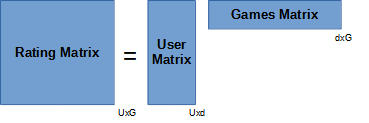

* *U* is the number of users
* *G* is the number of games
* *d* is the number of features we want to use to model the interaction

Then, the problem becomes how to construct "User Matrix" and "User-Item Interaction Matrix", so that their product is as close to the original rating matrix as possible.

If our rating matrix do not have any missing values, it would be easy to use singular value decomposition. Then, we would be left with:

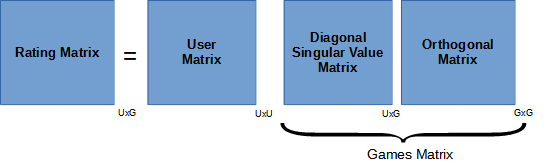

Usually, we decide how many features we want to use by the singular values and keep the highest *d* features. Then, SVD becomes:

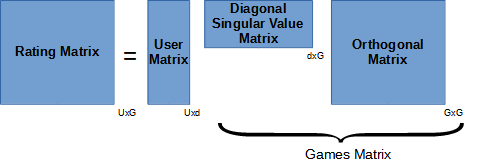

The problem is, our rating matrix is very sparse (99.5% of its entries are NaN). To reiterate why this became a problem in ratings, but it didn't with the purchase data;

* In purchase data, we only have 1s and 0s (User owns the game, or not). There is no concept of missing information.
* In ratings data, we created the matrix according to the playtime per user and mapped it between 1 and 10. In this matrix, 0 would imply a user has given a bad rating to all the games she didn't play. However, this is not the case, and actually, those are the values we want to fill in. We want to mark these values as missing, and then find such a factorization, that when we check the product of the User and Games Matrices, we will have a filled in rating matrix. Then, we will use this rating matrix to visualize the data on 2D.

## Funk SVD

Simon Funk's idea was to use only the values we know, and use an optimization algorithm (e.g. Gradient Descent) to minimize the Root Mean Squared Error.

So, what we are going to do is the following:

1. Initialize the user and game matrices randomly.
2. Minimize the RMSE between the known ratings, and the dot product between the corresponding user and game.

In our case, our goal is not to create a function that generalizes so we can use it for new users and games that will come in. Our goal is to fill in the rating matrix. Therefore, we won't do a train/validation/test split.

In [12]:
rating_matrix.shape

(3466, 3564)

In [13]:
d = 40

In [14]:
class FunkSVD(torch.nn.Module):
    def __init__(self, user_num, game_num, d):
        super(FunkSVD, self).__init__()
        self.u = torch.nn.Parameter(torch.rand((user_num, d)))
        self.g = torch.nn.Parameter(torch.rand((d, game_num)))
        self.d = d
        
    def forward(self, user_id, game_id):
        rating_prediction = torch.bmm(self.u[user_id, :].view(-1, 1, self.d),
                                      self.g[:, game_id].view(-1, self.d, 1)).view(-1, 1)
        return rating_prediction

In [15]:
train_set, test_set = train_test_split(data, test_size=0.1, random_state=0)
train_set, val_set = train_test_split(train_set, test_size=1/9, random_state=0)

In [16]:
class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, train=False, val=False, test=False):
        self.data = None
        if train:
            self.data = train_set.copy()
        elif val:
            self.data = val_set.copy()
        elif test:
            self.data = test_set.copy()
        
    def __getitem__(self, index):
        X = (self.data.user_enc.iloc[index], self.data.game_enc.iloc[index])
        y = torch.tensor(self.data.rating.iloc[index], dtype=torch.float)
        y = y.unsqueeze(0)
        return X, y
        
    def __len__(self):
        return len(self.data)

In [17]:
train_dataset = RatingDataset(train=True)
val_dataset = RatingDataset(val=True)
test_dataset = RatingDataset(test=True)

In [18]:
batch_size = 1024

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [19]:
model = FunkSVD(rating_matrix.shape[0], rating_matrix.shape[1], 40)

In [20]:
for i, (x, ratings) in enumerate(train_loader):
    user_ids = x[0]
    game_ids = x[1]
    c = ratings
    break

In [21]:
model = FunkSVD(rating_matrix.shape[0], rating_matrix.shape[1], 40)
criterion = torch.nn.MSELoss()
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)

epoch = 100

train_losses, val_losses = [], []


best_loss = -1
for e in range(epoch):
    model.train()
    epoch_loss = 0.0
    for i, (x, ratings) in enumerate(train_loader):
        user_ids = x[0]
        game_ids = x[1]
        
        output = model(user_ids, game_ids)
        loss = torch.sqrt(criterion(output, ratings))
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {e+1}, Train Mean Loss: {epoch_loss / len(train_loader)}")
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    epoch_loss = 0.0
    for i, (x, ratings) in enumerate(val_loader):
        user_ids = x[0]
        game_ids = x[1]
        
        output = model(user_ids, game_ids)
        loss = torch.sqrt(criterion(output, ratings))
        epoch_loss += loss.item()
        
    val_loss = epoch_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {e+1}, Validation Mean Loss: {val_loss}")
    
    if best_loss < 0 or val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/funk_svd_best_model.pth")
        print(f"Saved model at epoch {e+1}")

Epoch 1, Train Mean Loss: 5.521589487791061
Epoch 1, Validation Mean Loss: 5.479924281438191
Saved model at epoch 1
Epoch 2, Train Mean Loss: 5.434905141592026
Epoch 2, Validation Mean Loss: 5.393179655075073
Saved model at epoch 2
Epoch 3, Train Mean Loss: 5.339018911123276
Epoch 3, Validation Mean Loss: 5.308699131011963
Saved model at epoch 3
Epoch 4, Train Mean Loss: 5.257299413283666
Epoch 4, Validation Mean Loss: 5.2259377638498945
Saved model at epoch 4
Epoch 5, Train Mean Loss: 5.17602355281512
Epoch 5, Validation Mean Loss: 5.145200649897258
Saved model at epoch 5
Epoch 6, Train Mean Loss: 5.089638928572337
Epoch 6, Validation Mean Loss: 5.066322406133016
Saved model at epoch 6
Epoch 7, Train Mean Loss: 5.015474180380504
Epoch 7, Validation Mean Loss: 4.989313999811809
Saved model at epoch 7
Epoch 8, Train Mean Loss: 4.937141269445419
Epoch 8, Validation Mean Loss: 4.914332787195842
Saved model at epoch 8
Epoch 9, Train Mean Loss: 4.8617585599422455
Epoch 9, Validation Mean Lo

Epoch 70, Train Mean Loss: 3.0162367870410285
Epoch 70, Validation Mean Loss: 3.086353143056234
Saved model at epoch 70
Epoch 71, Train Mean Loss: 3.0050000747044883
Epoch 71, Validation Mean Loss: 3.0819790760676065
Saved model at epoch 71
Epoch 72, Train Mean Loss: 3.0105547507603965
Epoch 72, Validation Mean Loss: 3.077968955039978
Saved model at epoch 72
Epoch 73, Train Mean Loss: 3.0062654316425323
Epoch 73, Validation Mean Loss: 3.074047406514486
Saved model at epoch 73
Epoch 74, Train Mean Loss: 2.994225228826205
Epoch 74, Validation Mean Loss: 3.0704133907953897
Saved model at epoch 74
Epoch 75, Train Mean Loss: 2.998069395621618
Epoch 75, Validation Mean Loss: 3.066838184992472
Saved model at epoch 75
Epoch 76, Train Mean Loss: 2.9840339670578637
Epoch 76, Validation Mean Loss: 3.0635109742482505
Saved model at epoch 76
Epoch 77, Train Mean Loss: 2.9912103364864984
Epoch 77, Validation Mean Loss: 3.0604927937189736
Saved model at epoch 77
Epoch 78, Train Mean Loss: 2.990779017

In [52]:
model = FunkSVD(rating_matrix.shape[0], rating_matrix.shape[1], 40)
model.load_state_dict(torch.load("../models/funk_svd_best_model.pth"))
model.eval()

FunkSVD()

In [53]:
lr = 1
optimizer = optim.Adagrad(model.parameters(), lr=lr)

for e in range(110, 100+epoch):
    model.train()
    epoch_loss = 0.0
    for i, (x, ratings) in enumerate(train_loader):
        user_ids = x[0]
        game_ids = x[1]
        
        output = model(user_ids, game_ids)
        loss = torch.sqrt(criterion(output, ratings))
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {e+1}, Train Mean Loss: {epoch_loss / len(train_loader)}")
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    epoch_loss = 0.0
    for i, (x, ratings) in enumerate(val_loader):
        user_ids = x[0]
        game_ids = x[1]
        
        output = model(user_ids, game_ids)
        loss = torch.sqrt(criterion(output, ratings))
        epoch_loss += loss.item()
        
    val_loss = epoch_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {e+1}, Validation Mean Loss: {val_loss}")
    
    if best_loss < 0 or val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/funk_svd_best_model.pth")
        print(f"Saved model at epoch {e+1}")

Epoch 111, Train Mean Loss: 8.417854885260263
Epoch 111, Validation Mean Loss: 7.354218403498332
Epoch 112, Train Mean Loss: 6.501570622126262
Epoch 112, Validation Mean Loss: 5.970514376958211
Epoch 113, Train Mean Loss: 5.452226966619492
Epoch 113, Validation Mean Loss: 5.226803461710612
Epoch 114, Train Mean Loss: 4.848236292600632
Epoch 114, Validation Mean Loss: 4.77439816792806
Epoch 115, Train Mean Loss: 4.488385260105133
Epoch 115, Validation Mean Loss: 4.589917421340942
Epoch 116, Train Mean Loss: 4.230647484461467
Epoch 116, Validation Mean Loss: 4.361318190892537
Epoch 117, Train Mean Loss: 4.02692411839962
Epoch 117, Validation Mean Loss: 4.210943857828776
Epoch 118, Train Mean Loss: 3.8822586437066398
Epoch 118, Validation Mean Loss: 4.026989499727885
Epoch 119, Train Mean Loss: 3.774461214741071
Epoch 119, Validation Mean Loss: 3.9566664695739746
Epoch 120, Train Mean Loss: 3.6515550861756005
Epoch 120, Validation Mean Loss: 3.846614201863607
Epoch 121, Train Mean Loss: 3

KeyboardInterrupt: 

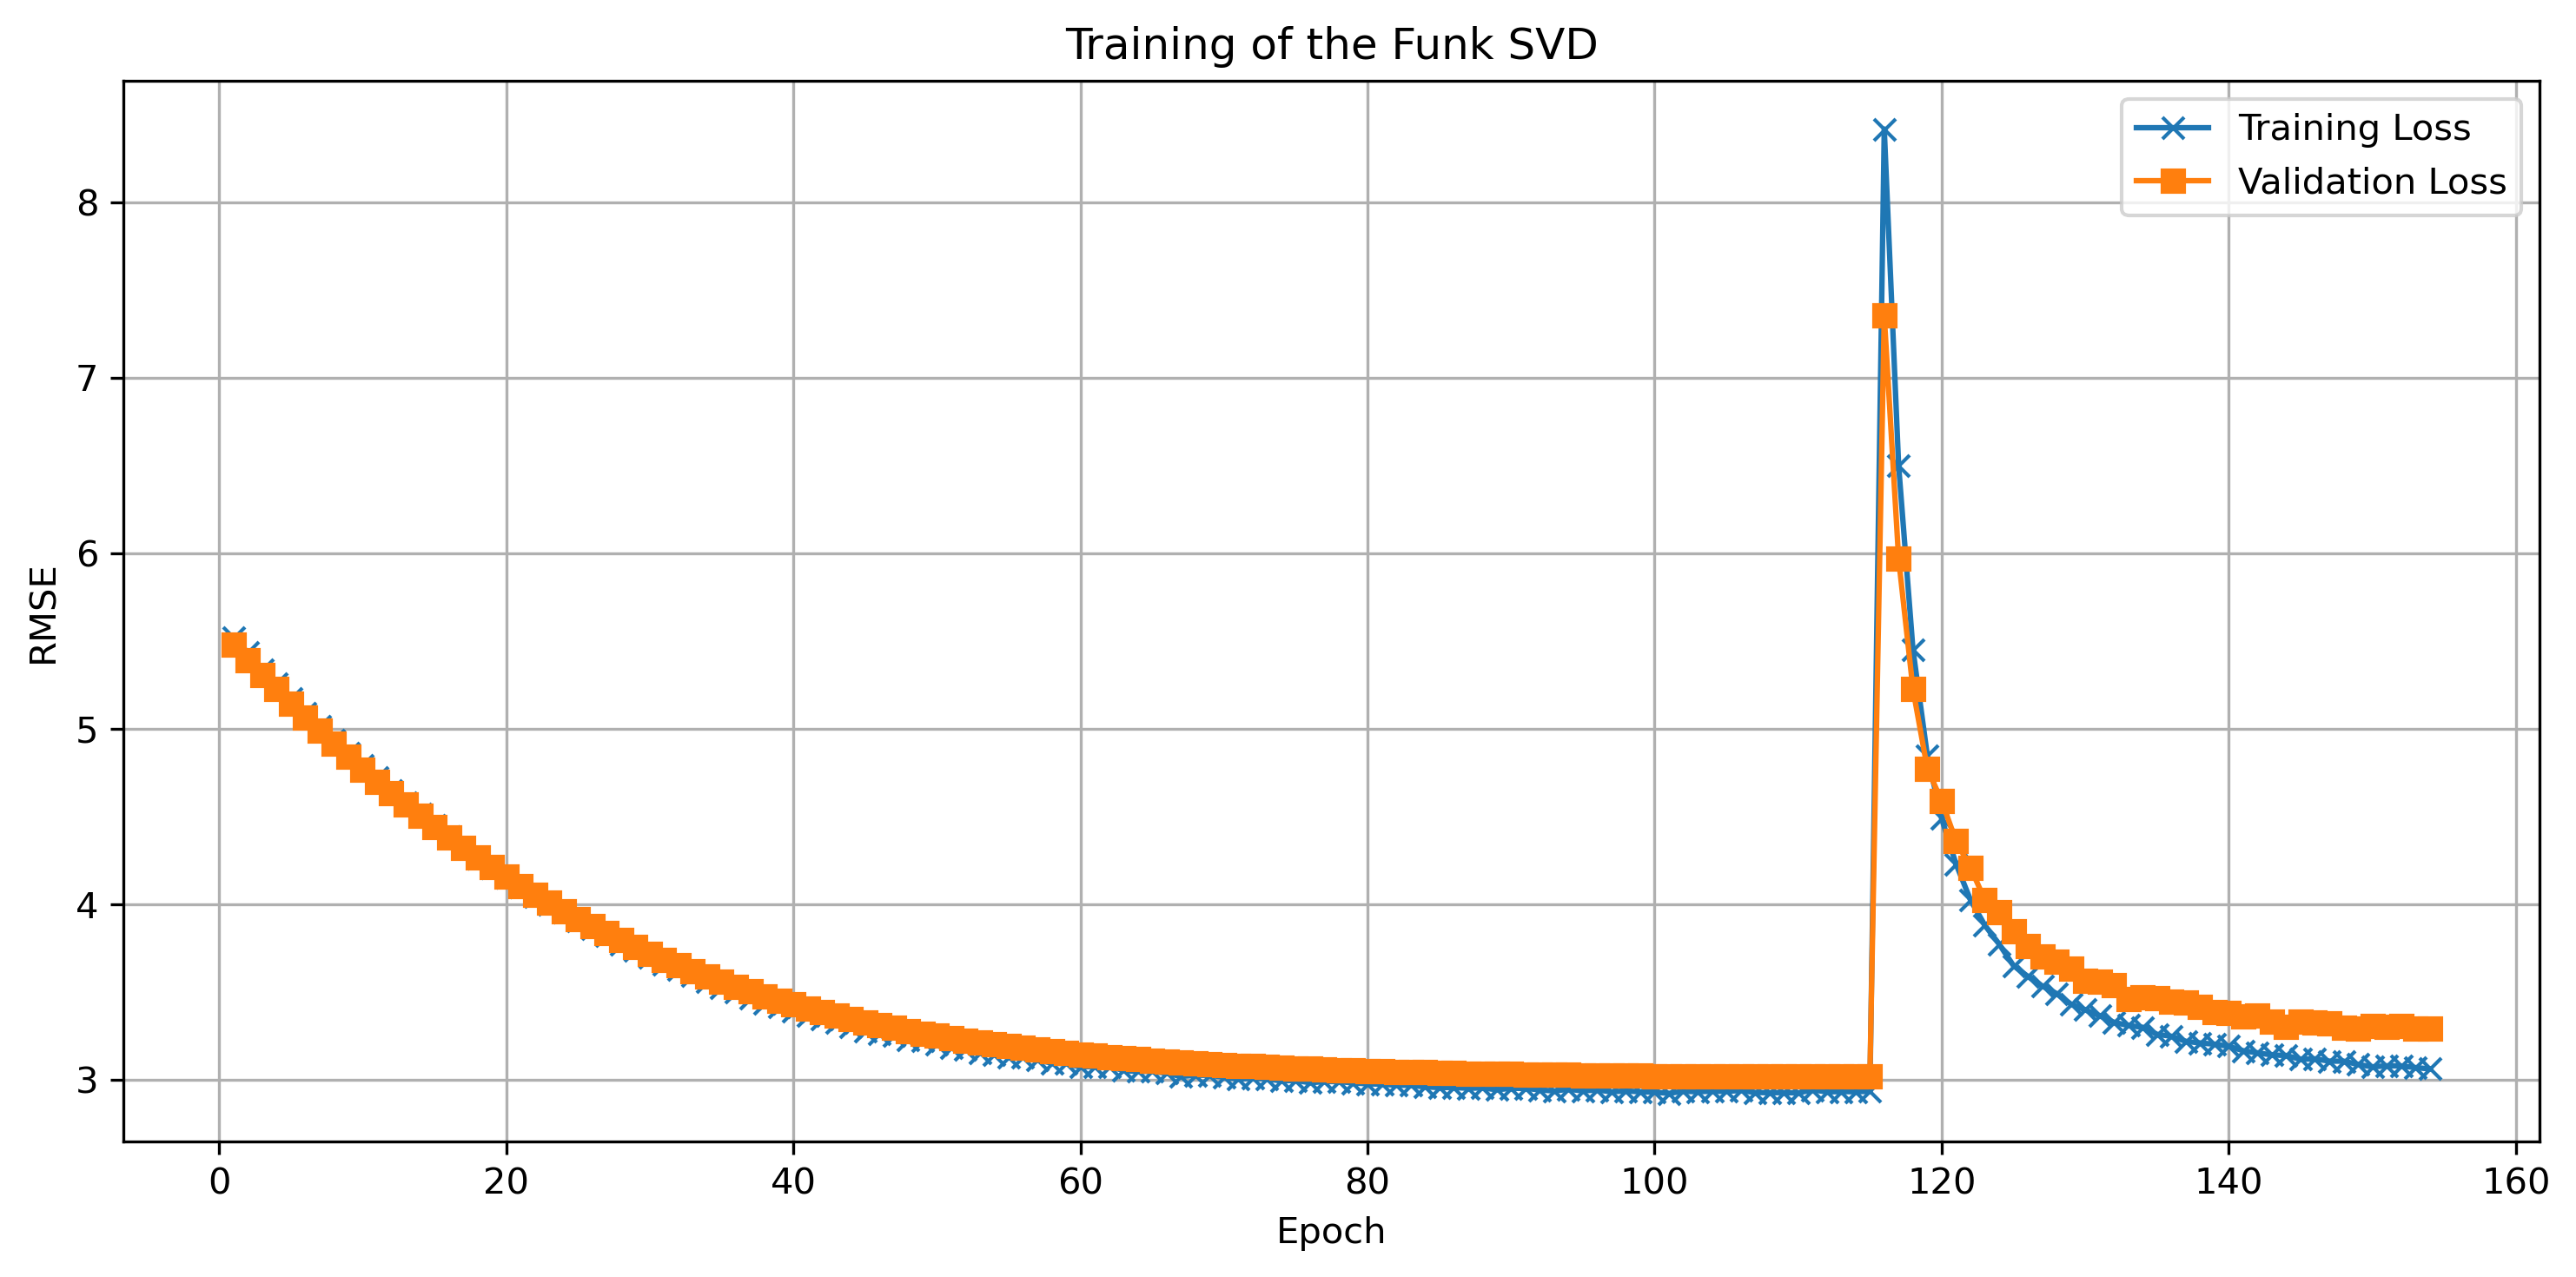

In [55]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(10, 5))

ax.set_title("Training of the Funk SVD")
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
ax.grid()

ax.plot(range(1, 155), train_losses, "-x", label="Training Loss")
ax.plot(range(1, 155), val_losses, "-s", label="Validation Loss")
ax.legend()

fig.tight_layout()

plt.show()

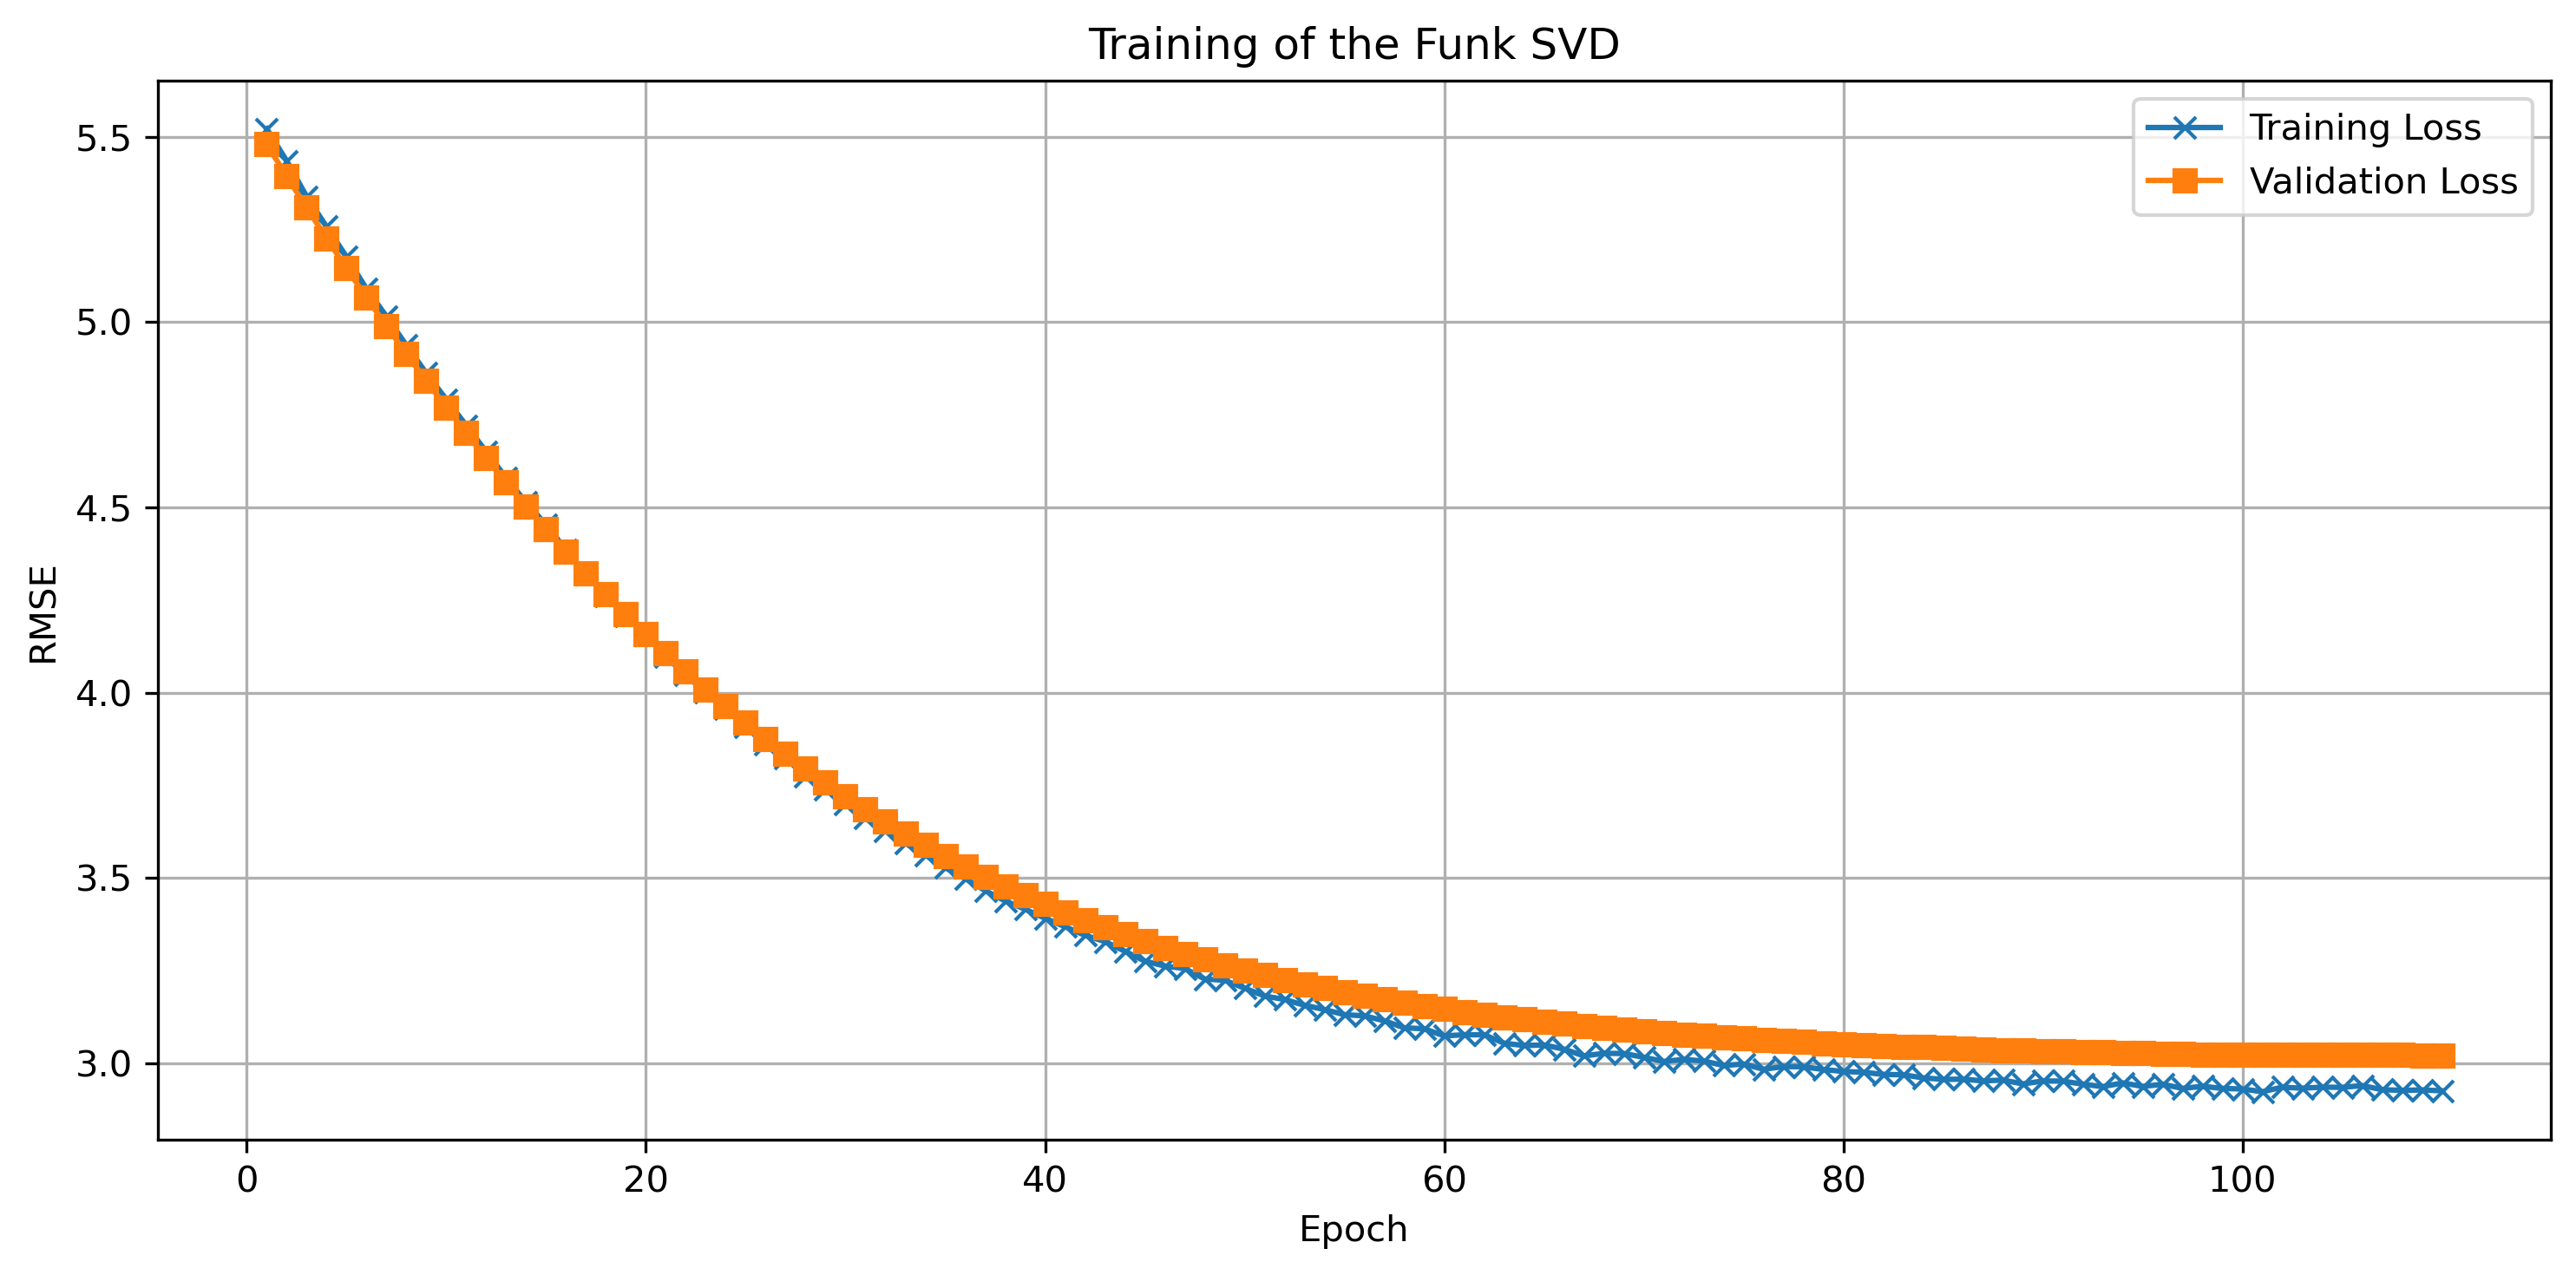

In [57]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(10, 5))

ax.set_title("Training of the Funk SVD")
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
ax.grid()

ax.plot(range(1, 111), train_losses[:110], "-x", label="Training Loss")
ax.plot(range(1, 111), val_losses[:110], "-s", label="Validation Loss")
ax.legend()

fig.tight_layout()

plt.show()

In [58]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1, 
                                           shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=1, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1, 
                                           shuffle=False)

model = FunkSVD(rating_matrix.shape[0], rating_matrix.shape[1], 40)
model.load_state_dict(torch.load("../models/funk_svd_best_model.pth"))
model.eval()


train_loss = 0.0
for i, (x, ratings) in enumerate(train_loader):
    user_ids = x[0]
    game_ids = x[1]

    output = model(user_ids, game_ids)
    loss = torch.sqrt(criterion(output, ratings))
    train_loss += loss.item()

print(f"Train Loss: {train_loss / len(train_set)}")

val_loss = 0.0
for i, (x, ratings) in enumerate(val_loader):
    user_ids = x[0]
    game_ids = x[1]

    output = model(user_ids, game_ids)
    loss = torch.sqrt(criterion(output, ratings))
    val_loss += loss.item()

print(f"Validation Loss: {val_loss / len(val_set)}")

test_loss = 0.0
for i, (x, ratings) in enumerate(test_loader):
    user_ids = x[0]
    game_ids = x[1]

    output = model(user_ids, game_ids)
    loss = torch.sqrt(criterion(output, ratings))
    test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_set)}")

Train Loss: 2.4940489681526765
Validation Loss: 2.552628907348741
Test Loss: 2.572990529451982


In [59]:
user_matrix = model.u.detach().numpy()
games_matrix = model.g.detach().numpy()

In [60]:
user_matrix.shape

(3466, 40)

In [61]:
games_matrix.shape

(40, 3564)

In [67]:
ratings_predicted = user_matrix @ games_matrix

In [68]:
ratings_predicted.min()

1.2707368

In [69]:
ratings_predicted.max()

15.8739395

In [70]:
pred_ratings_df = pd.DataFrame(ratings_predicted,
             columns=list(game_encoder.inverse_transform(np.array(pd.DataFrame(ratings_predicted).columns).reshape(-1, 1))[:, 0]),
             index=list(user_encoder.inverse_transform(np.array(pd.DataFrame(ratings_predicted).index).reshape(-1, 1))[:, 0]))

In [71]:
pred_ratings_df.describe()

007 Legends    0RBITALIS  \
count  3466.000000  3466.000000   
mean      7.689096     8.954792   
std       0.954004     1.053373   
min       5.096907     6.038949   
25%       6.975353     8.199168   
50%       7.651543     8.905234   
75%       8.353236     9.655826   
max      11.815862    12.620619   

       1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)  \
count                                        3466.000000            
mean                                            6.775816            
std                                             0.828567            
min                                             4.009387            
25%                                             6.185385            
50%                                             6.734689            
75%                                             7.309108            
max                                            10.012409            

       10 Second Ninja   10,000,000  100% Orange Juice    1000 Amps  \
count      3466.000000  3466.000000        3466.000000  3466.000000   
mean          8.780463     9.337887           8.725483     8.055885   
std           1.001022     1.091799           1.024502     0.961258   
min           6.043919     6.330040           5.858374     5.123126   
25%           8.053144     8.525607           7.969670     7.355906   
50%           8.718281     9.284293           8.656500     7.993173   
75%           9.458737    10.062429           9.378976     8.701795   
max          12.342908    13.734629          12.749981    11.880545   

       12 Labours of Hercules  12 Labours of Hercules II The Cretan Bull  \
count             3466.000000                                3466.000000   
mean                 7.752600                                   7.384227   
std                  0.905753                                   0.898078   
min                  4.912768                                   4.750962   
25%                  7.091141                                   6.727073   
50%                  7.700538                                   7.338103   
75%                  8.373067                                   7.961096   
max                 11.550789                                  11.026505   

       12 Labours of Hercules III Girl Power  ...      rFactor    rFactor 2  \
count                            3466.000000  ...  3466.000000  3466.000000   
mean                                8.623400  ...     8.554689     9.670087   
std                                 1.003424  ...     1.029381     1.091875   
min                                 5.698669  ...     5.492559     6.747747   
25%                                 7.928154  ...     7.829851     8.880521   
50%                                 8.573366  ...     8.512216     9.615292   
75%                                 9.290462  ...     9.226747    10.390800   
max                                12.153594  ...    12.485719    14.528973   

          realMyst  realMyst Masterpiece Edition  \
count  3466.000000                   3466.000000   
mean      7.225859                      7.736873   
std       0.942443                      0.947941   
min       4.319043                      4.753657   
25%       6.559160                      7.055146   
50%       7.191409                      7.702199   
75%       7.846783                      8.381490   
max      11.747407                     11.196324   

       resident evil 4 / biohazard 4   rymdkapsel  sZone-Online  \
count                    3466.000000  3466.000000   3466.000000   
mean                        7.559462     8.673461      5.504608   
std                         0.944819     1.047919      0.751205   
min                         4.534885     5.520015      3.047768   
25%                         6.885799     7.909436      4.970422   
50%                         7.516988     8.617263      5.485769   
75%                         8.202061     9.375614      5.980410   
max                        

In [72]:
pred_ratings_df["Counter-Strike"].describe()

count    3466.000000
mean        4.891847
std         0.683241
min         2.950390
25%         4.423694
50%         4.863757
75%         5.341276
max         7.635037
Name: Counter-Strike, dtype: float64

In [73]:
ratings_df = pd.DataFrame(rating_matrix,
             columns=list(game_encoder.inverse_transform(np.array(pd.DataFrame(ratings_predicted).columns).reshape(-1, 1))[:, 0]),
             index=list(user_encoder.inverse_transform(np.array(pd.DataFrame(ratings_predicted).index).reshape(-1, 1))[:, 0]))

In [74]:
ratings_df["Counter-Strike"].describe()

count    378.000000
mean       4.238271
std        3.479604
min        1.000000
25%        1.000000
50%        2.800000
75%        7.750000
max       10.000000
Name: Counter-Strike, dtype: float64

In [75]:
pred_ratings_df["Counter-Strike"].describe()

count    3466.000000
mean        4.891847
std         0.683241
min         2.950390
25%         4.423694
50%         4.863757
75%         5.341276
max         7.635037
Name: Counter-Strike, dtype: float64

In [76]:
pred_ratings_df["The Witcher 2 Assassins of Kings Enhanced Edition"].describe()

count    3466.000000
mean        4.204538
std         0.708346
min         2.049612
25%         3.710778
50%         4.184757
75%         4.680140
max         6.720372
Name: The Witcher 2 Assassins of Kings Enhanced Edition, dtype: float64

In [77]:
ratings_df["The Witcher 2 Assassins of Kings Enhanced Edition"].describe()

count    168.000000
mean       5.351214
std        2.970402
min        1.000000
25%        2.572532
50%        4.794425
75%        8.237791
max       10.000000
Name: The Witcher 2 Assassins of Kings Enhanced Edition, dtype: float64

In [78]:
ratings_df["The Witcher 3 Wild Hunt"].describe()

count    77.000000
mean      6.384231
std       2.624380
min       1.000000
25%       4.738462
50%       7.120000
75%       8.522388
max      10.000000
Name: The Witcher 3 Wild Hunt, dtype: float64

In [79]:
pred_ratings_df["The Witcher 3 Wild Hunt"].describe()

count    3466.000000
mean        5.894618
std         0.760504
min         3.538134
25%         5.336625
50%         5.861597
75%         6.409892
max         8.578558
Name: The Witcher 3 Wild Hunt, dtype: float64

In [80]:
pred_ratings_df["The Witcher Enhanced Edition"].describe()

count    3466.000000
mean        4.628332
std         0.586182
min         2.986661
25%         4.203799
50%         4.593768
75%         5.034618
max         6.703990
Name: The Witcher Enhanced Edition, dtype: float64

In [81]:
ratings_df["The Witcher Enhanced Edition"].describe()

count    119.000000
mean       4.472362
std        2.913564
min        1.000000
25%        1.654762
50%        3.700000
75%        7.000000
max       10.000000
Name: The Witcher Enhanced Edition, dtype: float64

In [92]:
np.sqrt(np.square(pred_ratings_df).sum(axis=0))["The Witcher 3 Wild Hunt"]

349.90747

In [96]:
normalized_df = pred_ratings_df / np.sqrt(np.square(pred_ratings_df).sum(axis=0))

In [97]:
np.square(normalized_df["The Witcher 3 Wild Hunt"]).sum()

1.0000012

We normalized the columns so cosine similarity can work better.

In [113]:
def cos_sim(x, y):
    return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))

In [117]:
similarity_matrix = normalized_df.corr(cos_sim)

In [129]:
similarity_matrix["The Witcher 2 Assassins of Kings Enhanced Edition"].sort_values(ascending=False)[:20]

The Witcher 2 Assassins of Kings Enhanced Edition    1.000000
Back to the Future Ep 4 - Double Visions             0.994189
Caribbean!                                           0.993760
Dragon's Lair                                        0.993543
Republique                                           0.993347
The Typing of The Dead Overkill                      0.993301
Pressure                                             0.993291
STAR WARS X-Wing Alliance                            0.993217
Shiny The Firefly                                    0.993065
Electronic Super Joy                                 0.992993
Shadow Harvest Phantom Ops                           0.992960
Capsized                                             0.992935
Skara - The Blade Remains                            0.992913
POSTAL 2                                             0.992874
GTR Evolution                                        0.992820
Triple Town                                          0.992758
Grimm   

In [133]:
cosine_similarity(np.array(normalized_df["The Witcher 2 Assassins of Kings Enhanced Edition"]).reshape(1, -1),
                  np.array(normalized_df["The Witcher 3 Wild Hunt"]).reshape(1, -1))

array([[0.98533547]], dtype=float32)

In [134]:
cosine_similarity(np.array(normalized_df["The Witcher 2 Assassins of Kings Enhanced Edition"]).reshape(1, -1),
                  np.array(normalized_df["Caribbean!"]).reshape(1, -1))

array([[0.9937599]], dtype=float32)

In [136]:
cosine_similarity(np.array(pred_ratings_df["The Witcher 2 Assassins of Kings Enhanced Edition"]).reshape(1, -1),
                  np.array(pred_ratings_df["The Witcher 3 Wild Hunt"]).reshape(1, -1))

array([[0.9853354]], dtype=float32)

In [137]:
cosine_similarity(np.array(pred_ratings_df["The Witcher 2 Assassins of Kings Enhanced Edition"]).reshape(1, -1),
                  np.array(pred_ratings_df["Caribbean!"]).reshape(1, -1))

array([[0.9937595]], dtype=float32)

In [205]:
from sklearn.manifold import TSNE

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of 

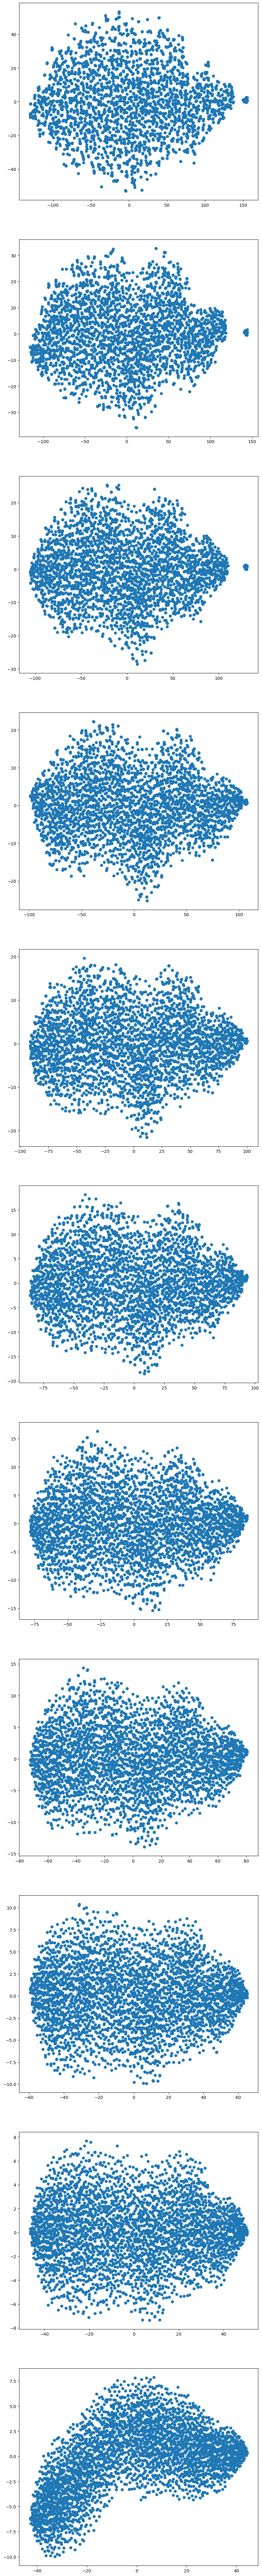

In [216]:
perplexity_values = [5, 10, 15, 20, 25, 30, 40, 50, 100, 150, 200]

fig, ax = plt.subplots(len(perplexity_values), 1, figsize=(10, 10 * len(perplexity_values)), dpi=100)

for i, perp in enumerate(perplexity_values):
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='pca', random_state=0, perplexity=perp).fit_transform(pred_ratings_df)
    ax[i].scatter(X_embedded[:, 0], X_embedded[:, 1])

plt.show()

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


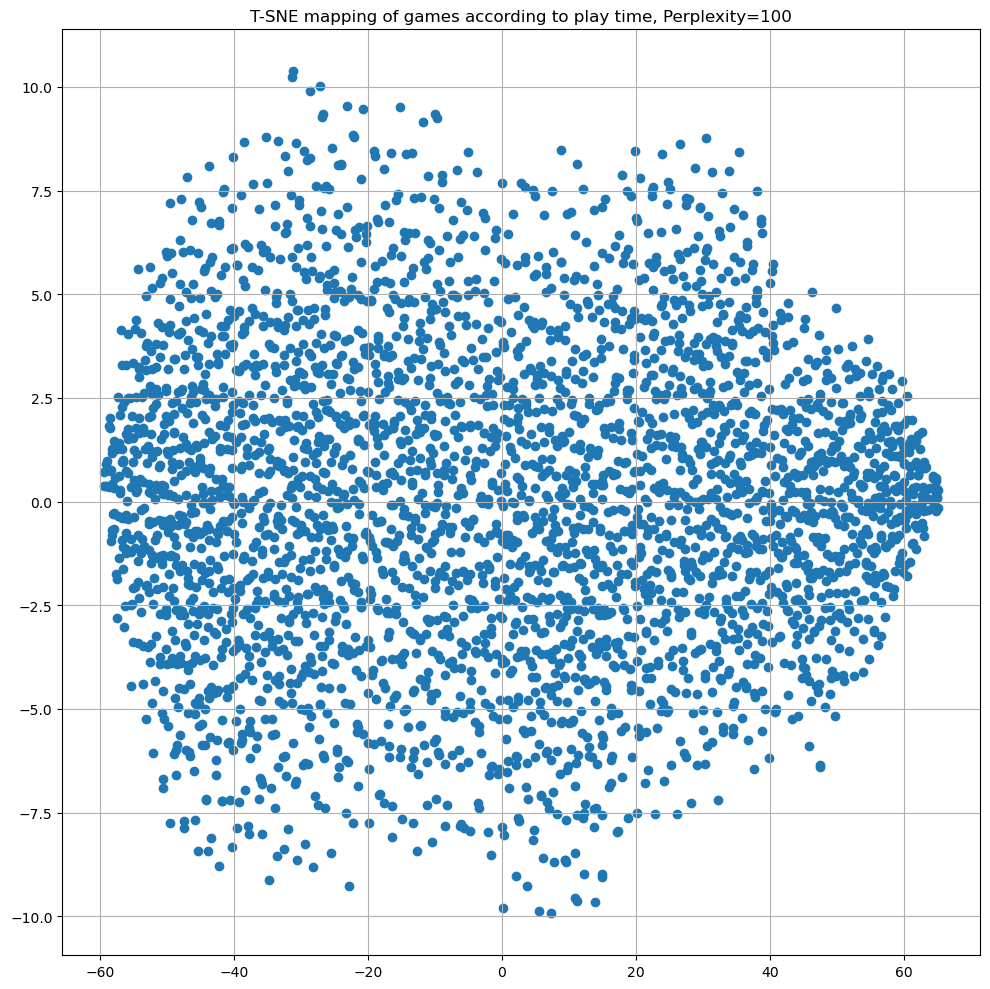

In [217]:
perp = 100

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='pca', random_state=0, perplexity=perp).fit_transform(pred_ratings_df)

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)

ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

ax.set_title(f"T-SNE mapping of games according to play time, Perplexity={perp}")
ax.grid()
fig.tight_layout()
plt.show()

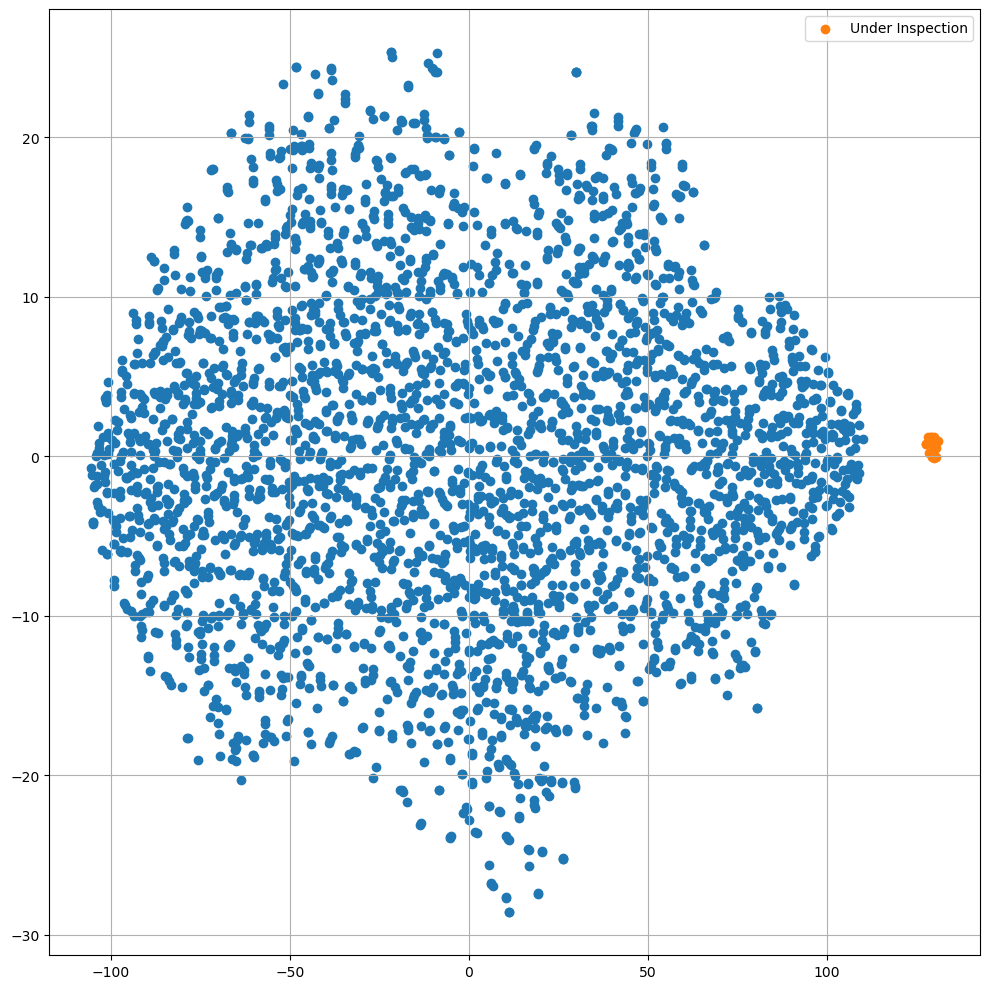

Amnesia Memories
Angry Birds Space
Black Fire
Blackwell Convergence
Breach & Clear
CID The Dummy
ComaMortuary
David.
Divinity Dragon Commander Beta
Genesis Online
Heavy Fire Afghanistan
Shadowrun Hong Kong
Spriter Pro
Take On Helicopters
The Samaritan Paradox
Thief Town
Without Within


In [209]:
indices = np.where(np.logical_and(np.logical_and(X_embedded[:, 0] > 120, X_embedded[:, 0] < 200),
           np.logical_and(X_embedded[:, 1] > -5, X_embedded[:, 1] < 5)))[0]

not_indices = [i for i in range(len(X_embedded)) if i not in indices]

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)

ax.scatter(X_embedded[not_indices, 0], X_embedded[not_indices, 1])
ax.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label="Under Inspection")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

cluster_games = game_encoder.inverse_transform(indices.reshape(-1, 1))
for game in list(cluster_games[:, 0]):
    print(game)

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of 

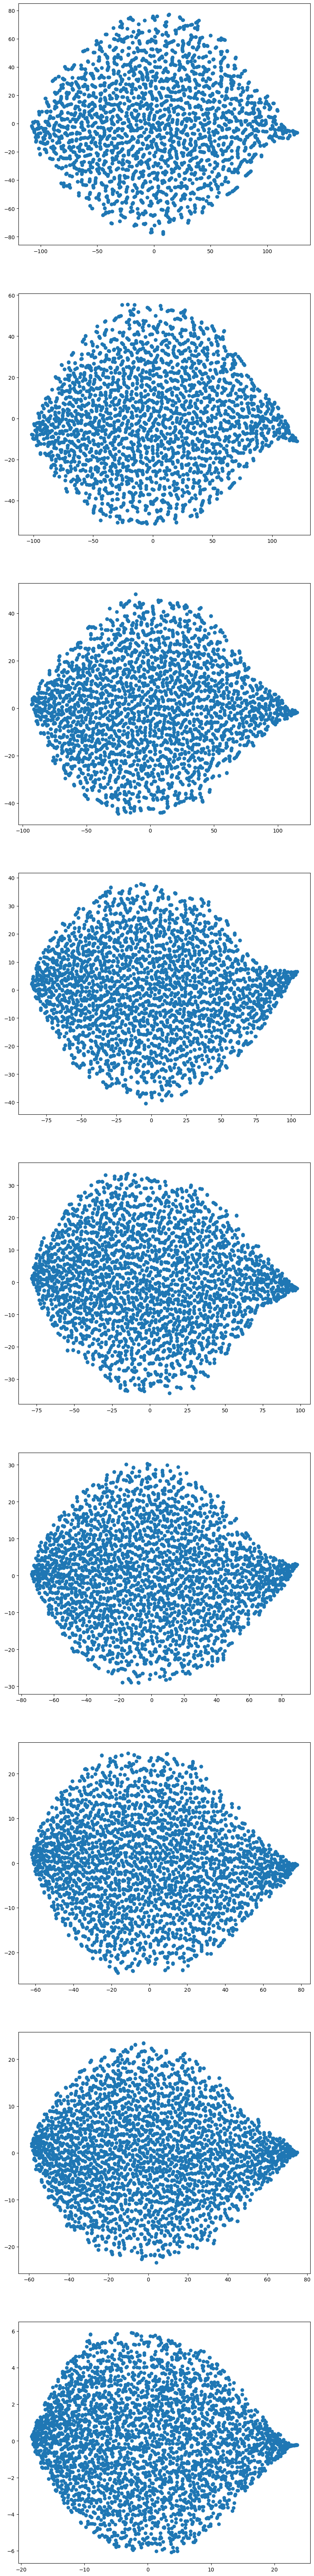

In [218]:
perplexity_values = [5, 10, 15, 20, 25, 30, 40, 50, 100]

fig, ax = plt.subplots(len(perplexity_values), 1, figsize=(10, 10 * len(perplexity_values)), dpi=100)

for i, perp in enumerate(perplexity_values):
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='pca', random_state=0, perplexity=perp).fit_transform(similarity_matrix)
    ax[i].scatter(X_embedded[:, 0], X_embedded[:, 1])

plt.show()

Clearly, using the cosine similarity and the our newly created ratings didn't work. Then, a positive side of the Funk SVD is that, it can also work with other types of matrices. So, we can directly use play times.

In [138]:
rating_matrix = coo_matrix((np.array(data.actionValue), (np.array(data.user_enc), np.array(data.game_enc))),
           shape=((data.user_enc.max() + 1, data.game_enc.max() + 1)),
           dtype=np.float64).toarray()

rating_matrix[rating_matrix == 0] = np.nan

In [198]:
train_set, test_set = train_test_split(data, test_size=0.1, random_state=0)
train_set, val_set = train_test_split(train_set, test_size=1/9, random_state=0)

In [219]:
train_set.shape

(49014, 6)

In [220]:
val_set.shape

(6127, 6)

In [221]:
test_set.shape

(6127, 6)

In [199]:
class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, train=False, val=False, test=False):
        self.data = None
        if train:
            self.data = train_set.copy()
        elif val:
            self.data = val_set.copy()
        elif test:
            self.data = test_set.copy()
        
    def __getitem__(self, index):
        X = (self.data.user_enc.iloc[index], self.data.game_enc.iloc[index])
        y = torch.tensor(self.data.actionValue.iloc[index], dtype=torch.float)
        y = y.unsqueeze(0)
        return X, y
        
    def __len__(self):
        return len(self.data)

In [200]:
train_dataset = RatingDataset(train=True)
val_dataset = RatingDataset(val=True)
test_dataset = RatingDataset(test=True)

batch_size = 1024

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [203]:
model = FunkSVD(rating_matrix.shape[0], rating_matrix.shape[1], 40)
criterion = torch.nn.MSELoss()
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr)

epoch = 1000

train_losses, val_losses = [], []


best_loss = -1
for e in range(epoch):
    model.train()
    epoch_loss = 0.0
    for i, (x, ratings) in enumerate(train_loader):
        user_ids = x[0]
        game_ids = x[1]
        
        output = model(user_ids, game_ids)
        loss = torch.sqrt(criterion(output, ratings))
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {e+1}, Train Mean Loss: {epoch_loss / len(train_loader)}")
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    epoch_loss = 0.0
    for i, (x, ratings) in enumerate(val_loader):
        user_ids = x[0]
        game_ids = x[1]
        
        output = model(user_ids, game_ids)
        loss = torch.sqrt(criterion(output, ratings))
        epoch_loss += loss.item()
        
    val_loss = epoch_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {e+1}, Validation Mean Loss: {val_loss}")
    
    if best_loss < 0 or val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/funk_svd_playtime_best.pth")
        print(f"Saved model at epoch {e+1}")

Epoch 1, Train Mean Loss: 192.26642560958862
Epoch 1, Validation Mean Loss: 219.6936264038086
Saved model at epoch 1
Epoch 2, Train Mean Loss: 191.80585273106894
Epoch 2, Validation Mean Loss: 219.69357554117838
Saved model at epoch 2
Epoch 3, Train Mean Loss: 191.66539223988852
Epoch 3, Validation Mean Loss: 219.69351959228516
Saved model at epoch 3
Epoch 4, Train Mean Loss: 191.29419406255087
Epoch 4, Validation Mean Loss: 219.69346618652344
Saved model at epoch 4
Epoch 5, Train Mean Loss: 190.4616758028666
Epoch 5, Validation Mean Loss: 219.69341532389322
Saved model at epoch 5
Epoch 6, Train Mean Loss: 190.2117288907369
Epoch 6, Validation Mean Loss: 219.69334920247397
Saved model at epoch 6
Epoch 7, Train Mean Loss: 192.52172009150186
Epoch 7, Validation Mean Loss: 219.69330342610678
Saved model at epoch 7
Epoch 8, Train Mean Loss: 192.64058669408163
Epoch 8, Validation Mean Loss: 219.69325510660806
Saved model at epoch 8
Epoch 9, Train Mean Loss: 192.1520274480184
Epoch 9, Valida

KeyboardInterrupt: 

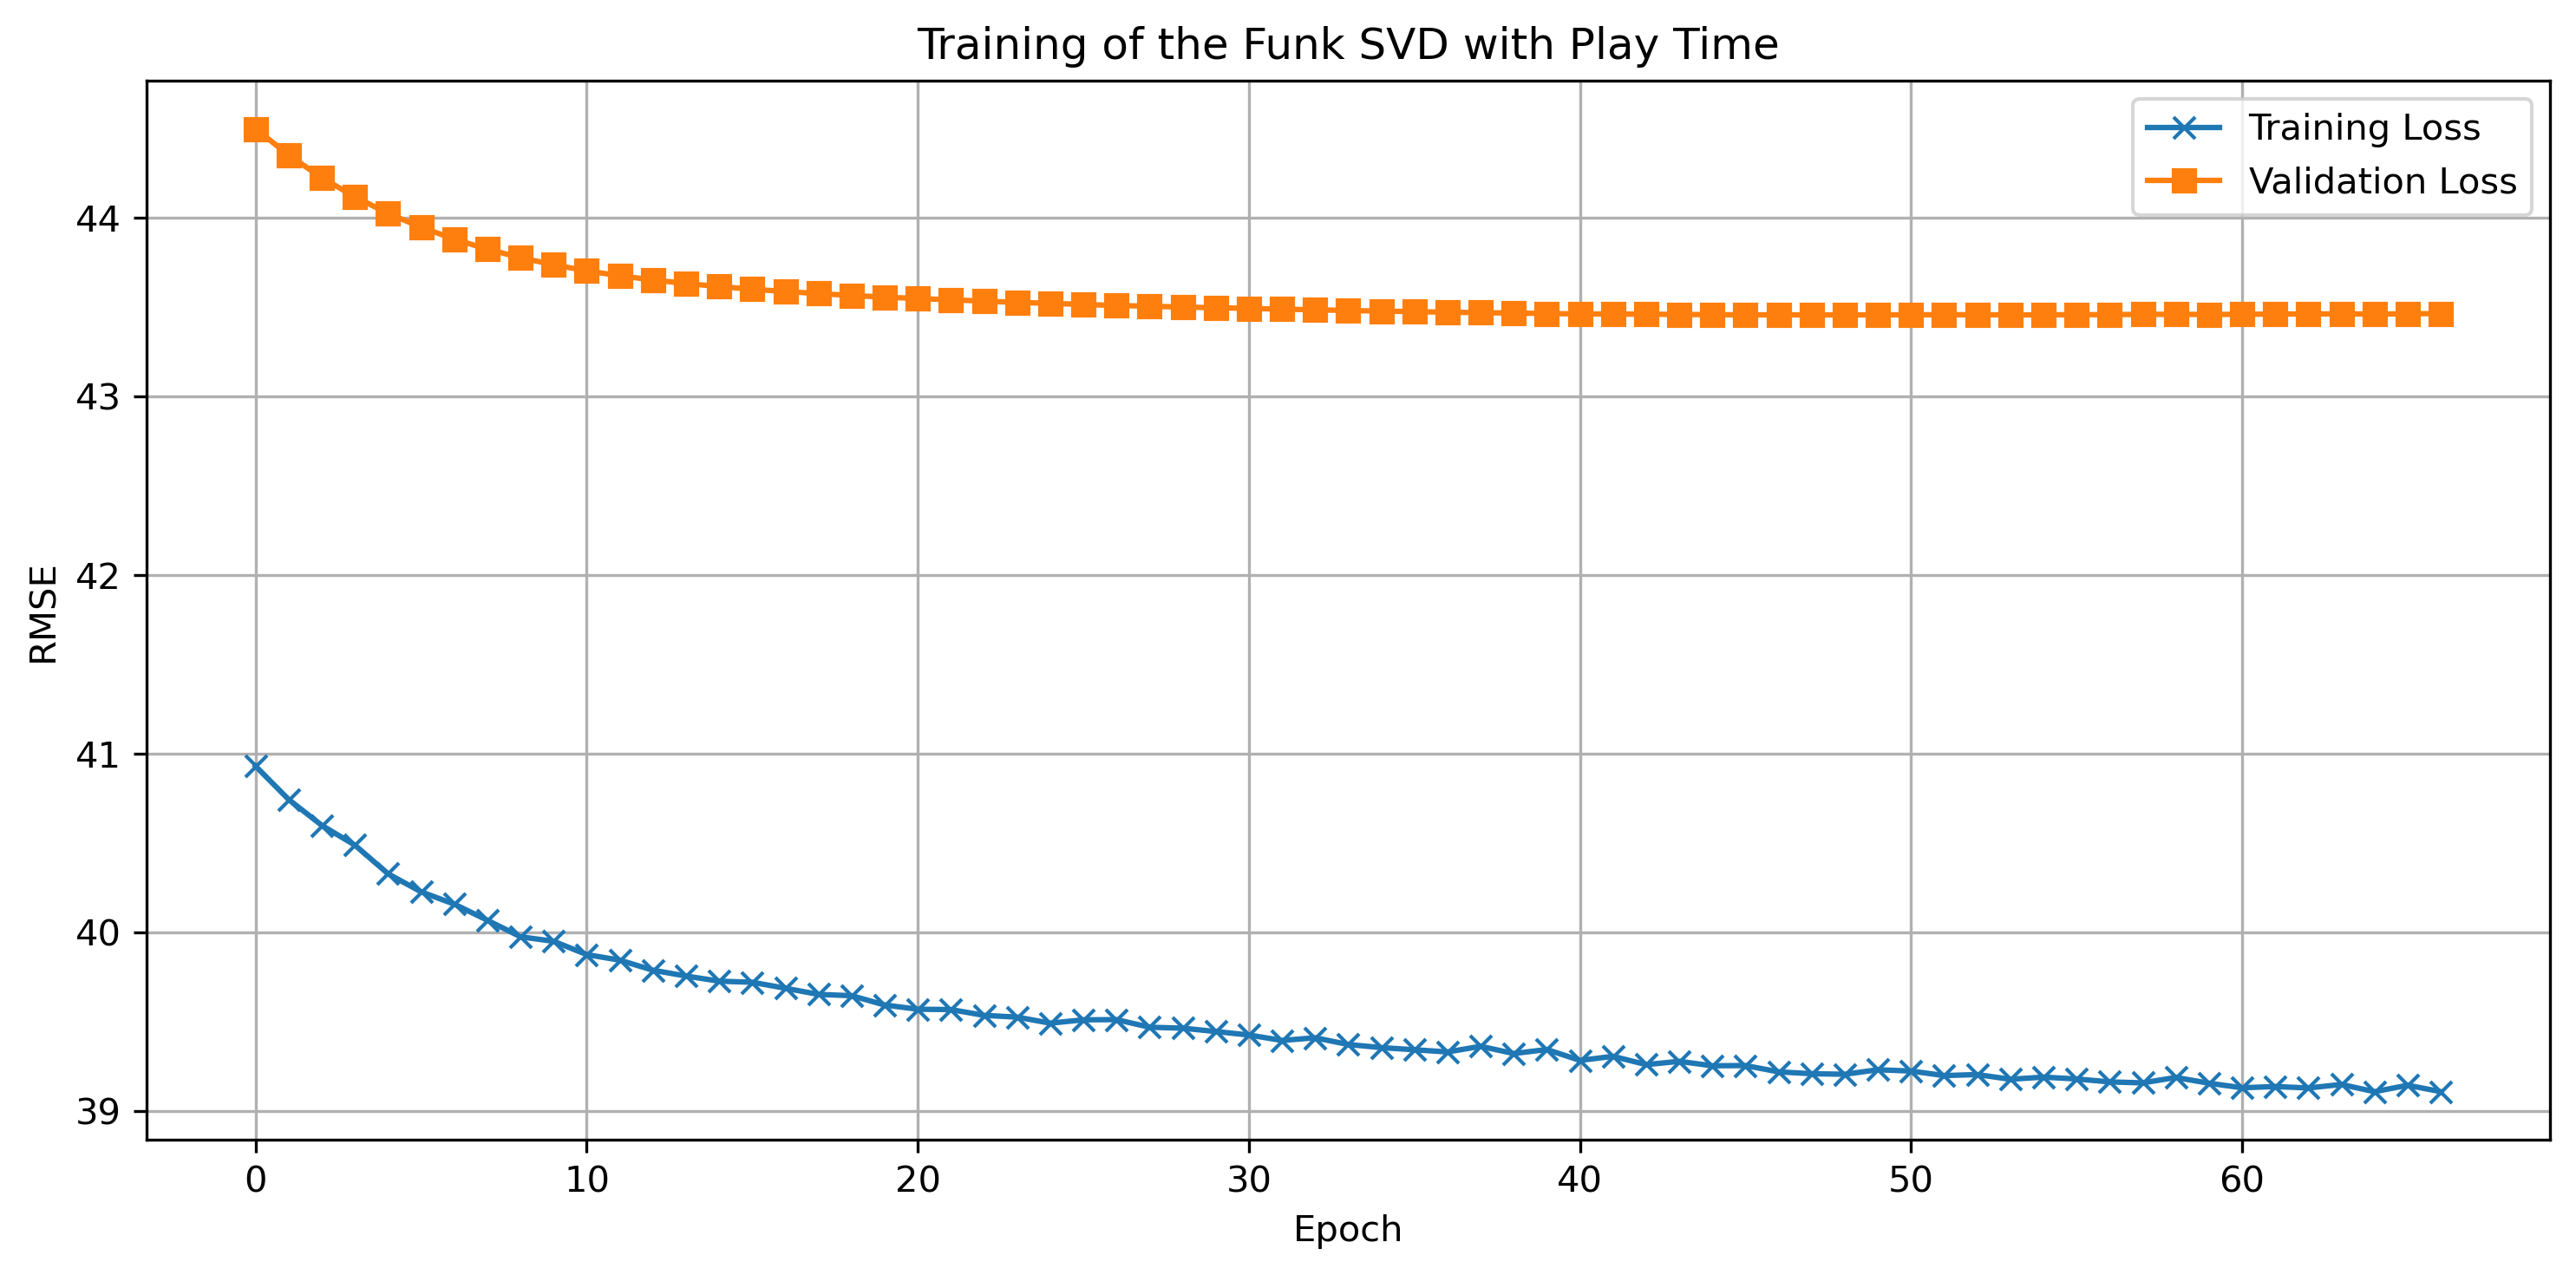

In [155]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(10, 5))

ax.set_title("Training of the Funk SVD with Play Time")
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
ax.grid()

ax.plot(range(len(train_losses)), train_losses, "-x", label="Training Loss")
ax.plot(range(len(val_losses)), val_losses, "-s", label="Validation Loss")
ax.legend()

fig.tight_layout()

plt.show()

In [193]:
class NonLinearFunkSVD(torch.nn.Module):
    def __init__(self, user_num, game_num, d):
        super(NonLinearFunkSVD, self).__init__()
        self.u = torch.nn.Parameter(torch.rand((user_num, d)))
        self.g = torch.nn.Parameter(torch.rand((d, game_num)))
        self.d = d
        
        
        self.relu = torch.nn.ReLU()
        
        self.fc = torch.nn.Linear(2*d, d)
        self.fc2 = torch.nn.Linear(d, 1)
        
    def forward(self, user_id, game_id):
#         out = torch.bmm(self.u[user_id, :].view(-1, 1, self.d),
#                                       self.g[:, game_id].view(-1, self.d, 1)).view(-1, 1)
        out = torch.cat((self.u[user_id, :].view(-1, self.d),
                        self.g[:, game_id].view(-1, self.d)), 1)
    
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [197]:
model = NonLinearFunkSVD(rating_matrix.shape[0], rating_matrix.shape[1], 40)
criterion = torch.nn.SmoothL1Loss()
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr)

epoch = 1000

train_losses, val_losses = [], []


best_loss = -1
for e in range(epoch):
    model.train()
    epoch_loss = 0.0
    for i, (x, ratings) in enumerate(train_loader):
        user_ids = x[0]
        game_ids = x[1]
        
        output = model(user_ids, game_ids)
        loss = criterion(output, ratings)
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {e+1}, Train Mean Loss: {epoch_loss / len(train_loader)}")
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    epoch_loss = 0.0
    for i, (x, ratings) in enumerate(val_loader):
        user_ids = x[0]
        game_ids = x[1]
        
        output = model(user_ids, game_ids)
        loss = criterion(output, ratings)
        epoch_loss += loss.item()
        
    val_loss = epoch_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {e+1}, Validation Mean Loss: {val_loss}")
    
    if best_loss < 0 or val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/funk_svd_playtime_nn.pth")
        print(f"Saved model at epoch {e+1}")

Epoch 1, Train Mean Loss: 41.296314080556236
Epoch 1, Validation Mean Loss: 44.98730278015137
Saved model at epoch 1
Epoch 2, Train Mean Loss: 41.13815267880758
Epoch 2, Validation Mean Loss: 44.82575289408366
Saved model at epoch 2
Epoch 3, Train Mean Loss: 40.99656331539154
Epoch 3, Validation Mean Loss: 44.673251469930015
Saved model at epoch 3
Epoch 4, Train Mean Loss: 40.835619846979775
Epoch 4, Validation Mean Loss: 44.535589853922524
Saved model at epoch 4
Epoch 5, Train Mean Loss: 40.70829379558563
Epoch 5, Validation Mean Loss: 44.41611862182617
Saved model at epoch 5
Epoch 6, Train Mean Loss: 40.60859628518423
Epoch 6, Validation Mean Loss: 44.31299908955892
Saved model at epoch 6
Epoch 7, Train Mean Loss: 40.50821661949158
Epoch 7, Validation Mean Loss: 44.22417322794596
Saved model at epoch 7
Epoch 8, Train Mean Loss: 40.40604821840922
Epoch 8, Validation Mean Loss: 44.14908218383789
Saved model at epoch 8
Epoch 9, Train Mean Loss: 40.36454017957052
Epoch 9, Validation Mean

KeyboardInterrupt: 